# Importing Libraries

In [1]:
import os 
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras 
from keras.callbacks import EarlyStopping,ModelCheckpoint
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
from imblearn.over_sampling import SMOTE

In [16]:
import skimage.io
from tensorflow.keras.applications.resnet50 import ResNet50
from skimage.io import imread, imshow
from skimage.transform import resize
from tensorflow.keras.layers import InputLayer, BatchNormalization, Dropout, Flatten, Dense, Activation, MaxPool2D, Conv2D
from tensorflow.keras.models import Sequential

# Loading Dataset

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from PIL import Image

In [3]:
data_dir = "./Alzheimer_s Dataset/train"
classes = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
print(os.listdir(data_dir))

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


In [4]:
images = []
labels = []
for subfolder in tqdm(os.listdir('./Alzheimer_s Dataset')):
    subfolder_path = os.path.join('./Alzheimer_s Dataset', subfolder)
    for folder in os.listdir(subfolder_path):
        subfolder_path2=os.path.join(subfolder_path,folder)
        for image_filename in os.listdir(subfolder_path2):
            image_path = os.path.join(subfolder_path2, image_filename)
            images.append(image_path)
            labels.append(folder)
df = pd.DataFrame({'image': images, 'label': labels})
df

100%|██████████| 2/2 [00:00<00:00,  4.13it/s]


,image,label
0,./Alzheimer_s Dataset\test\MildDemented\26 (19...,MildDemented
1,./Alzheimer_s Dataset\test\MildDemented\26 (20...,MildDemented
2,./Alzheimer_s Dataset\test\MildDemented\26 (21...,MildDemented
3,./Alzheimer_s Dataset\test\MildDemented\26 (22...,MildDemented
4,./Alzheimer_s Dataset\test\MildDemented\26 (23...,MildDemented
...,...,...
6395,./Alzheimer_s Dataset\train\VeryMildDemented\v...,VeryMildDemented
6396,./Alzheimer_s Dataset\train\VeryMildDemented\v...,VeryMildDemented
6397,./Alzheimer_s Dataset\train\VeryMildDemented\v...,VeryMildDemented
6398,./Alzheimer_s Dataset\train\VeryMildDemented\v...,VeryMildDemented


# Displaying images from dataset

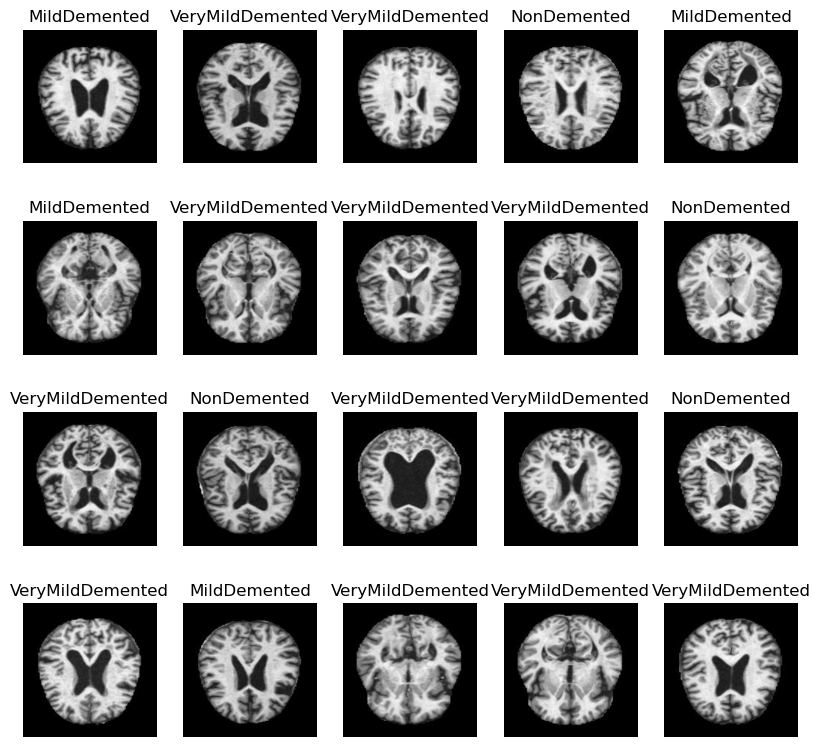

In [5]:
plt.figure(figsize=(10,12))
for n,i in enumerate(np.random.randint(0,len(df),20)):
    plt.subplot(5,5,n+1)
    img=cv2.imread(df.image[i])
    img=cv2.resize(img,(224,224))
    img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.axis('off')
    plt.title(df.label[i],fontsize=12)

# Resizing and generating augmented images

In [5]:
Size=(176,176)
work_dr = ImageDataGenerator(
    rescale = 1./255
)
train_data_gen = work_dr.flow_from_dataframe(df,x_col='image',y_col='label', target_size=Size, batch_size=6500, shuffle=False)

Found 6400 validated image filenames belonging to 4 classes.


In [6]:
train_data, train_labels = train_data_gen.next()

In [10]:
for alzheimers_class in classes:
    container = []
    temp_dir = data_dir + "/" + alzheimers_class
    for file in os.listdir(temp_dir):
        container.append(file)
    print(alzheimers_class, ": ", len(container))

MildDemented :  717
ModerateDemented :  52
NonDemented :  2560
VeryMildDemented :  1792


# Balance classes

In [11]:
import imblearn
sm = imblearn.over_sampling.SMOTE(random_state=42)
train_data, train_labels = sm.fit_resample(train_data.reshape(-1, 176 * 176 * 3), train_labels)
train_data = train_data.reshape(-1, 176,176, 3)
print(train_data.shape, train_labels.shape)

(12800, 176, 176, 3) (12800, 4)


In [12]:
from collections import Counter
class_counts = Counter(np.argmax(train_labels, axis=1))
for class_idx, count in class_counts.items():
    print(f"Class {class_idx}: {count} samples")

Class 0: 3200 samples
Class 1: 3200 samples
Class 2: 3200 samples
Class 3: 3200 samples


# Splitting dataset into train,test,val set

In [13]:
X_train, X_test1, y_train, y_test1 = train_test_split(train_data,train_labels, test_size=0.3, random_state=42,shuffle=True,stratify=train_labels)
X_val, X_test, y_val, y_test = train_test_split(X_test1,y_test1, test_size=0.5, random_state=42,shuffle=True,stratify=y_test1)
print('X_train shape is ' , X_train.shape)
print('X_test shape is ' , X_test.shape)
print('X_val shape is ' , X_val.shape)
print('y_train shape is ' , y_train.shape)
print('y_test shape is ' , y_test.shape)
print('y_val shape is ' , y_val.shape)

X_train shape is  (8960, 176, 176, 3)
X_test shape is  (1920, 176, 176, 3)
X_val shape is  (1920, 176, 176, 3)
y_train shape is  (8960, 4)
y_test shape is  (1920, 4)
y_val shape is  (1920, 4)


# Adding layers to Inception V3

In [12]:
base_model = tf.keras.applications.InceptionV3(input_shape=(176,176,3),include_top=False,weights='imagenet')
base_model.trainable = False

model_Inception=keras.models.Sequential()
model_Inception.add(base_model)
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.GlobalAveragePooling2D()) 
model_Inception.add(keras.layers.Flatten()) 
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(512,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(256,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(128,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.Dense(64,activation=tf.nn.relu))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dropout(.5))
model_Inception.add(keras.layers.BatchNormalization())
model_Inception.add(keras.layers.Dense(4, activation=tf.nn.softmax))
model_Inception.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 4, 4, 2048)        21802784  
                                                                 
 dropout (Dropout)           (None, 4, 4, 2048)        0         
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 batch_normalization_94 (Ba  (None, 2048)              8192      
 tchNormalization)                                               
                                                                 
 dense (Dense)               (None, 512)              

# Training CNN Model

In [13]:
checkpoint_cb = ModelCheckpoint("inception.h5", save_best_only=True)
early_stopping_cb =EarlyStopping(patience=10, restore_best_weights=True)
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]
model_Inception.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=METRICS)
hist = model_Inception.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=[checkpoint_cb, early_stopping_cb])


Epoch 1/50

280/280 [==============================] - ETA: 0s - loss: 1.3327 - acc: 0.4249 - auc: 0.7027

C:\Users\Bhumi\AppData\Roaming\Python\Python311\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


280/280 [==============================] - 297s 999ms/step - loss: 1.3327 - acc: 0.4249 - auc: 0.7027 - val_loss: 0.7942 - val_acc: 0.6198 - val_auc: 0.8815
Epoch 2/50
280/280 [==============================] - 269s 960ms/step - loss: 0.8805 - acc: 0.5991 - auc: 0.8587 - val_loss: 0.6858 - val_acc: 0.6693 - val_auc: 0.9098
Epoch 3/50
280/280 [==============================] - 274s 980ms/step - loss: 0.7641 - acc: 0.6453 - auc: 0.8922 - val_loss: 0.6285 - val_acc: 0.6969 - val_auc: 0.9241
Epoch 4/50
280/280 [==============================] - 270s 965ms/step - loss: 0.6947 - acc: 0.6862 - auc: 0.9118 - val_loss: 0.5831 - val_acc: 0.7250 - val_auc: 0.9364
Epoch 5/50
280/280 [==============================] - 272s 972ms/step - loss: 0.6482 - acc: 0.7121 - auc: 0.9233 - val_loss: 0.5371 - val_acc: 0.7583 - val_auc: 0.9475
Epoch 6/50
280/280 [==============================] - 270s 963ms/step - loss: 0.6290 - acc: 0.7202 - auc: 0.9279 - val_loss: 0.5090 - val_acc: 0.7844 - val_auc: 0.9541
Epo

# Saving Model architecture and history of training

In [14]:
model_Inception.save('CNN_Model.keras')
#cnn_model = models.load_model('CNNModel.keras')
import pickle
with open('cnnmodeltraining_history.pkl', 'wb') as file:
    pickle.dump(hist.history, file)

#history_df = pd.DataFrame(history.history)
#history_df.to_csv('cnntraining_history.csv', index=False)
#with open('cnntraining_history.pkl', 'rb') as file:
    #history = pickle.load(file)

#history_df = pd.read_csv('cnntraining_history.csv')

# Convert the DataFrame back to a dictionary
#history = history_df.to_dict(orient='list')

# Plotting loss, acc,auc vs epochs

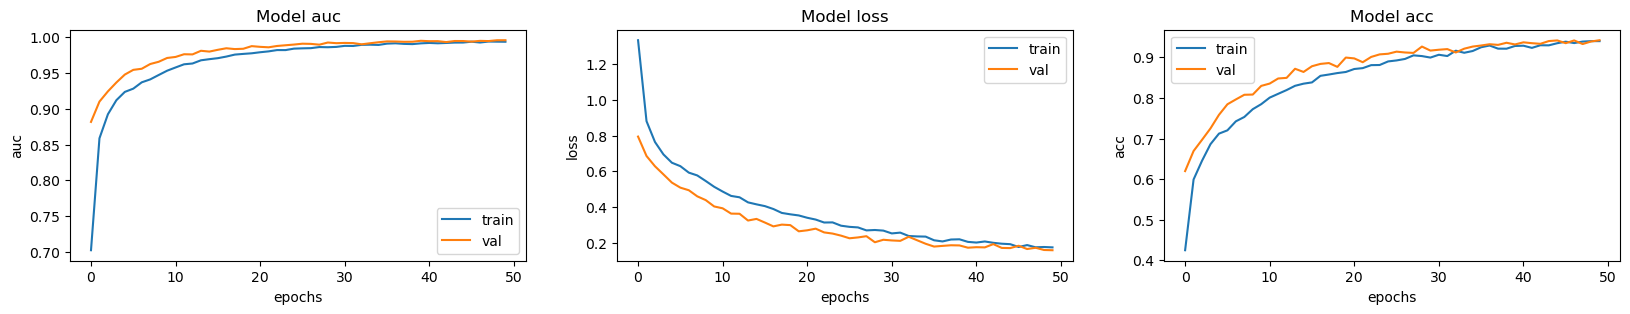

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss', 'acc']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

# Testing Accuracy

In [17]:
score, acc,auc= model_Inception.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 [==============================] - 31s 515ms/step - loss: 0.1534 - acc: 0.9406 - auc: 0.9951
Test Loss = 0.15338291227817535
Test Accuracy = 0.940625011920929


# Predictions

In [18]:
y_pred = model_Inception.predict(X_test)

60/60 [==============================] - 34s 514ms/step


In [20]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in y_pred:
    labels = roundoff(labels)

# Classification report and Confusion Matrix

In [21]:
print(classification_report(y_test, y_pred, target_names=classes))

                  precision    recall  f1-score   support

    MildDemented       0.97      0.99      0.98       480
ModerateDemented       1.00      1.00      1.00       480
     NonDemented       0.91      0.87      0.89       480
VeryMildDemented       0.88      0.90      0.89       480

       micro avg       0.94      0.94      0.94      1920
       macro avg       0.94      0.94      0.94      1920
    weighted avg       0.94      0.94      0.94      1920
     samples avg       0.94      0.94      0.94      1920



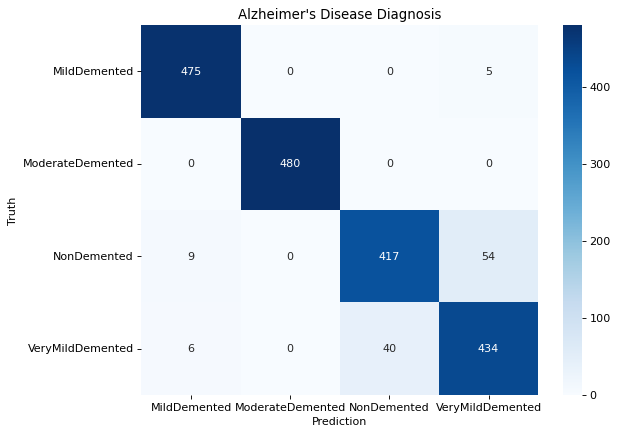

In [22]:
pred_ls = np.argmax(y_pred, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)

In [ ]:
#Resnet-50 model

In [14]:
base_modelresnet = ResNet50(input_shape=(176,176,3), 
                   include_top=False,
                   weights="imagenet")
base_modelresnet.trainable = False



94765736/94765736 [==============================] - 18s 0us/step


In [15]:
base_modelresnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 176, 176, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 182, 182, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 88, 88, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 88, 88, 64)           256       ['conv1_conv[0][0]']          
 on)                                                                                       

                                                                                                  
 conv2_block3_1_conv (Conv2  (None, 44, 44, 64)           16448     ['conv2_block2_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv2_block3_1_bn (BatchNo  (None, 44, 44, 64)           256       ['conv2_block3_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv2_block3_1_relu (Activ  (None, 44, 44, 64)           0         ['conv2_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv2_blo

 ation)                                                                                           
                                                                                                  
 conv3_block2_3_conv (Conv2  (None, 22, 22, 512)          66048     ['conv3_block2_2_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv3_block2_3_bn (BatchNo  (None, 22, 22, 512)          2048      ['conv3_block2_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv3_block2_add (Add)      (None, 22, 22, 512)          0         ['conv3_block1_out[0][0]',    
                                                                     'conv3_block2_3_bn[0][0]']   
          

 conv4_block1_2_conv (Conv2  (None, 11, 11, 256)          590080    ['conv4_block1_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv4_block1_2_bn (BatchNo  (None, 11, 11, 256)          1024      ['conv4_block1_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block1_2_relu (Activ  (None, 11, 11, 256)          0         ['conv4_block1_2_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv4_block1_0_conv (Conv2  (None, 11, 11, 1024)         525312    ['conv3_block4_out[0][0]']    
 D)       

                                                                                                  
 conv4_block3_out (Activati  (None, 11, 11, 1024)         0         ['conv4_block3_add[0][0]']    
 on)                                                                                              
                                                                                                  
 conv4_block4_1_conv (Conv2  (None, 11, 11, 256)          262400    ['conv4_block3_out[0][0]']    
 D)                                                                                               
                                                                                                  
 conv4_block4_1_bn (BatchNo  (None, 11, 11, 256)          1024      ['conv4_block4_1_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_blo

 D)                                                                                               
                                                                                                  
 conv4_block6_3_bn (BatchNo  (None, 11, 11, 1024)         4096      ['conv4_block6_3_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv4_block6_add (Add)      (None, 11, 11, 1024)         0         ['conv4_block5_out[0][0]',    
                                                                     'conv4_block6_3_bn[0][0]']   
                                                                                                  
 conv4_block6_out (Activati  (None, 11, 11, 1024)         0         ['conv4_block6_add[0][0]']    
 on)                                                                                              
          

 conv5_block3_1_relu (Activ  (None, 6, 6, 512)            0         ['conv5_block3_1_bn[0][0]']   
 ation)                                                                                           
                                                                                                  
 conv5_block3_2_conv (Conv2  (None, 6, 6, 512)            2359808   ['conv5_block3_1_relu[0][0]'] 
 D)                                                                                               
                                                                                                  
 conv5_block3_2_bn (BatchNo  (None, 6, 6, 512)            2048      ['conv5_block3_2_conv[0][0]'] 
 rmalization)                                                                                     
                                                                                                  
 conv5_block3_2_relu (Activ  (None, 6, 6, 512)            0         ['conv5_block3_2_bn[0][0]']   
 ation)   

In [17]:
model=Sequential()
model.add(base_modelresnet)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(64,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(32,kernel_initializer='he_uniform'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dense(4,activation='softmax'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 dropout (Dropout)           (None, 6, 6, 2048)        0         
                                                                 
 flatten (Flatten)           (None, 73728)             0         
                                                                 
 batch_normalization (Batch  (None, 73728)             294912    
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 64)                4718656   
                                                                 
 batch_normalization_1 (Bat  (None, 64)                256       
 chNormalization)                                       

In [19]:
checkpoint_cbr = ModelCheckpoint("resnet.keras", save_best_only=True)
early_stopping_cbr =EarlyStopping(patience=10, restore_best_weights=True)
METRICS = [tf.keras.metrics.CategoricalAccuracy(name='acc'),
           tf.keras.metrics.AUC(name='auc')]
model.compile(optimizer ='adam', loss='categorical_crossentropy', metrics=METRICS)
history = model.fit(X_train,y_train, epochs=50, validation_data=(X_val,y_val), callbacks=[checkpoint_cbr, early_stopping_cbr])


Epoch 1/50

280/280 [==============================] - 374s 1s/step - loss: 1.4310 - acc: 0.2965 - auc: 0.5621 - val_loss: 1.2042 - val_acc: 0.5208 - val_auc: 0.7874
Epoch 2/50
280/280 [==============================] - 359s 1s/step - loss: 1.1660 - acc: 0.4287 - auc: 0.7259 - val_loss: 0.8840 - val_acc: 0.5948 - val_auc: 0.8752
Epoch 3/50
280/280 [==============================] - 361s 1s/step - loss: 1.0013 - acc: 0.5036 - auc: 0.8021 - val_loss: 0.8069 - val_acc: 0.6339 - val_auc: 0.8916
Epoch 4/50
280/280 [==============================] - 353s 1s/step - loss: 0.9107 - acc: 0.5616 - auc: 0.8390 - val_loss: 0.7381 - val_acc: 0.6615 - val_auc: 0.9063
Epoch 5/50
280/280 [==============================] - 359s 1s/step - loss: 0.8592 - acc: 0.5905 - auc: 0.8588 - val_loss: 0.6965 - val_acc: 0.6677 - val_auc: 0.9141
Epoch 6/50
280/280 [==============================] - 349s 1s/step - loss: 0.8158 - acc: 0.6174 - auc: 0.8754 - val_loss: 0.6706 - val_acc: 0.6953 - val_auc: 0.9234
Epoch 7/

Epoch 48/50
280/280 [==============================] - 340s 1s/step - loss: 0.4779 - acc: 0.8035 - auc: 0.9584 - val_loss: 0.3250 - val_acc: 0.8729 - val_auc: 0.9837
Epoch 49/50
280/280 [==============================] - 432s 2s/step - loss: 0.4612 - acc: 0.8107 - auc: 0.9616 - val_loss: 0.3109 - val_acc: 0.8729 - val_auc: 0.9843
Epoch 50/50
280/280 [==============================] - 470s 2s/step - loss: 0.4661 - acc: 0.8067 - auc: 0.9607 - val_loss: 0.3167 - val_acc: 0.8750 - val_auc: 0.9845


In [20]:
model.save('Resnet_Model.keras')
#cnn_model = models.load_model('CNNModel.keras')
import pickle
with open('resnetmodeltraining_history.pkl', 'wb') as file:
    pickle.dump(history.history, file)

#history_df = pd.DataFrame(history.history)
#history_df.to_csv('cnntraining_history.csv', index=False)
#with open('cnntraining_history.pkl', 'rb') as file:
    #history = pickle.load(file)

#history_df = pd.read_csv('cnntraining_history.csv')

# Convert the DataFrame back to a dictionary
#history = history_df.to_dict(orient='list')

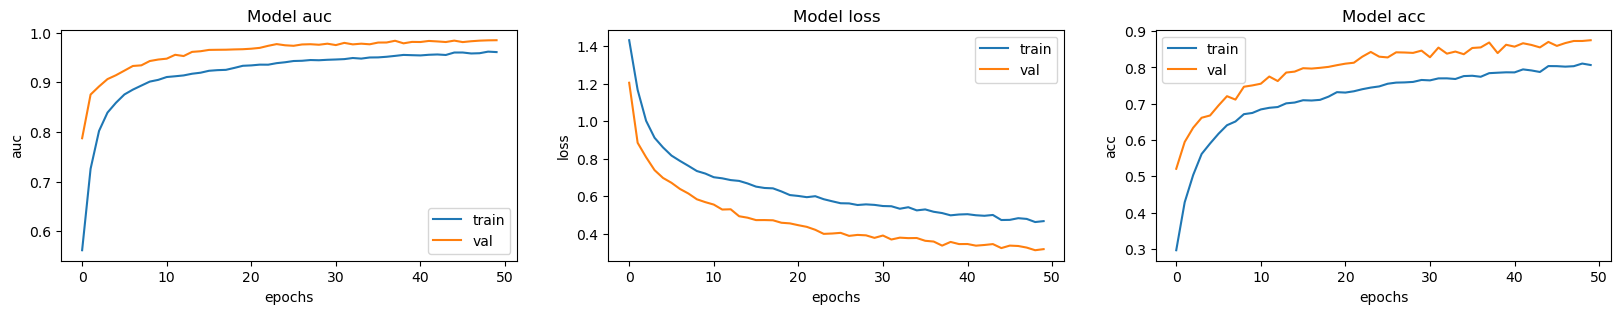

In [21]:
fig, ax = plt.subplots(1, 3, figsize=(20, 3))
ax = ax.ravel()

for i, met in enumerate(['auc', 'loss', 'acc']):
    ax[i].plot(history.history[met])
    ax[i].plot(history.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

In [22]:
score, acc,auc= model.evaluate(X_test,y_test)
print('Test Loss =', score)
print('Test Accuracy =', acc)

60/60 [==============================] - 80s 1s/step - loss: 0.3134 - acc: 0.8833 - auc: 0.9851
Test Loss = 0.3134419322013855
Test Accuracy = 0.8833333253860474


In [23]:
y_preds = model.predict(X_test)

60/60 [==============================] - 83s 1s/step


In [25]:
def roundoff(arr):
    arr[np.argwhere(arr != arr.max())] = 0
    arr[np.argwhere(arr == arr.max())] = 1
    return arr

for labels in y_preds:
    labels = roundoff(labels)

In [26]:
print(classification_report(y_test, y_preds, target_names=classes))

                  precision    recall  f1-score   support

    MildDemented       0.97      0.99      0.98       480
ModerateDemented       1.00      1.00      1.00       480
     NonDemented       0.92      0.62      0.74       480
VeryMildDemented       0.71      0.92      0.80       480

       micro avg       0.88      0.88      0.88      1920
       macro avg       0.90      0.88      0.88      1920
    weighted avg       0.90      0.88      0.88      1920
     samples avg       0.88      0.88      0.88      1920



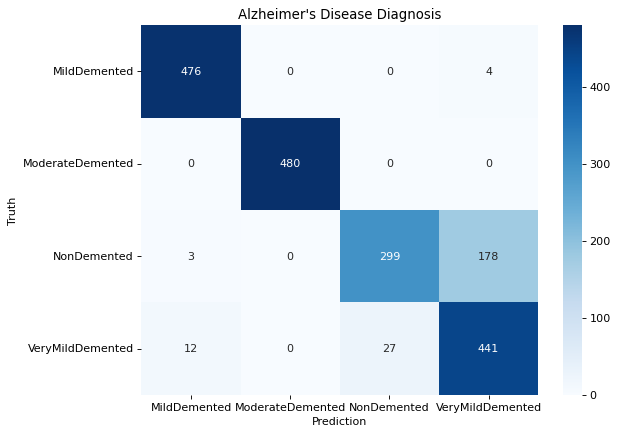

In [27]:
pred_ls = np.argmax(y_preds, axis=1)
test_ls = np.argmax(y_test, axis=1)

conf_arr = confusion_matrix(test_ls, pred_ls)
plt.figure(figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')

ax = sns.heatmap(conf_arr, cmap='Blues', annot=True, fmt='d', xticklabels=classes, yticklabels=classes)

plt.title('Alzheimer\'s Disease Diagnosis')
plt.xlabel('Prediction')
plt.ylabel('Truth')
plt.show(ax)